#  Deep Learning MURA Classification with DenseNet 201

## Load MURA

In [ ]:
#Download and unzip
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

!unzip -o -qq MURA-v1.1.zip

--2023-06-22 09:46:18--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  17.0MB/s    in 3m 10s  

2023-06-22 09:49:28 (17.0 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



## Load Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.applications.densenet import DenseNet201
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint

## Present Examples

In [ ]:
data_dir = 'MURA-v1.1'

train_dir = data_dir + '/train' # Path to train directory
val_dir = data_dir + '/valid' # Path to validation directory

ABNORMAL


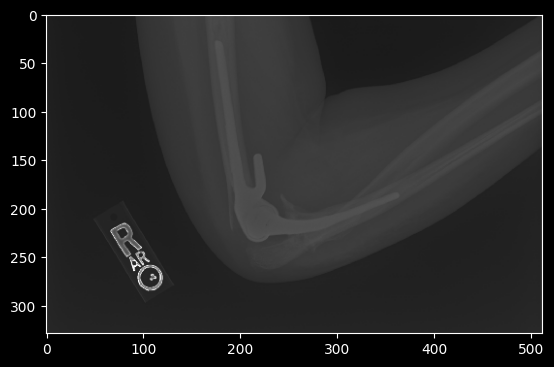

In [ ]:
# Display abnormal bone image
img_abnormal = load_img('MURA-v1.1/train/XR_ELBOW/patient00069/study1_positive/image2.png')
print('ABNORMAL')
plt.style.use('dark_background')
plt.imshow(img_abnormal)
plt.show()

NORMAL


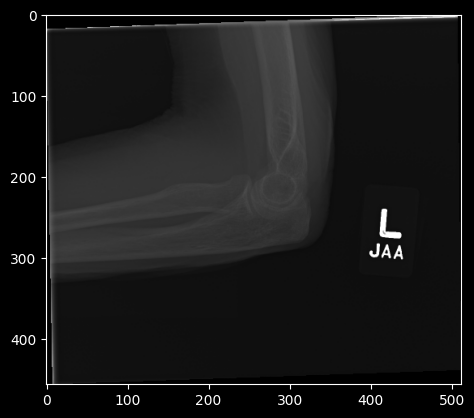

In [ ]:
# Display normal bone image
img_normal = load_img('MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image1.png')
print('NORMAL')
plt.imshow(img_normal)
plt.style.use('dark_background')
plt.show()

## Data Preparation

### Train Set

In [ ]:
#Train set studies with labels
df=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', names=['Train_Image','Train_Label'])

0    8280
1    5177
Name: Train_Label, dtype: int64


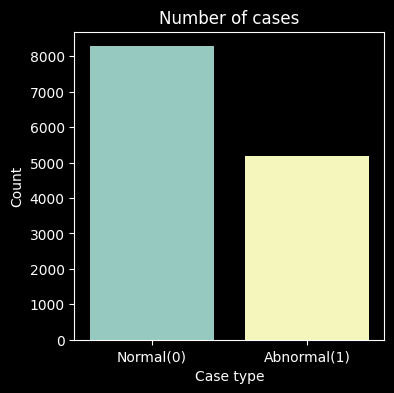

In [ ]:
#Count labels in train set
cases_count = df['Train_Label'].value_counts()
print(cases_count)

#Plot the results
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.style.use('dark_background')
plt.title('Number of cases', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

In [ ]:
#Adding labels to individual images in train set
df=pd.read_csv('MURA-v1.1/train_image_paths.csv', names=['Train_Image'])
names=df['Train_Image'].values
train_labels=[]


for i in names:
  if ('positive' in i):
    train_labels.append('1')
  elif('negative' in i):
    train_labels.append('0')

train_labels = np.array(train_labels)


df.insert(1, 'Train_Label', train_labels)
df.to_csv('Train_set.csv', index=False)

0    21935
1    14873
Name: Train_Label, dtype: int64


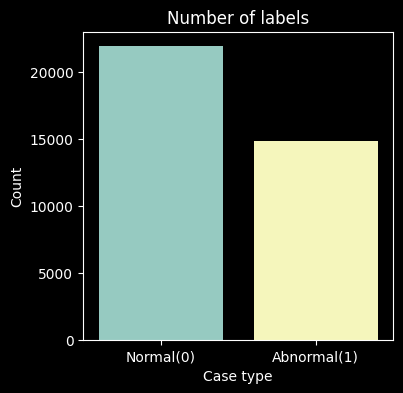

In [ ]:
#Count individual number of labels of images in train set
cases_count = df['Train_Label'].value_counts()
print(cases_count)

#Plot the results
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.style.use('dark_background')
plt.title('Number of labels', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

### Validation Set

In [ ]:
#Validation set studies with labels
df=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', names=['Valid_Image','Valid_Label'])

0    661
1    538
Name: Valid_Label, dtype: int64


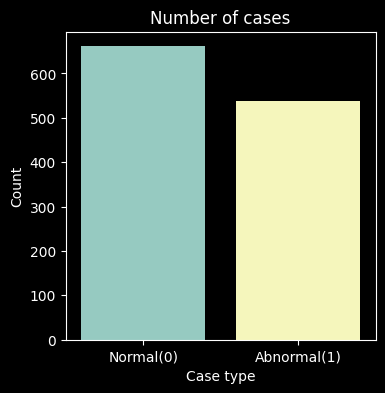

In [ ]:
#Count labels in validation set
cases_count = df['Valid_Label'].value_counts()
print(cases_count)

#Plot the results
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.style.use('dark_background')
plt.title('Number of cases', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

In [ ]:
#Adding labels to individual images in validation set
df=pd.read_csv('MURA-v1.1/valid_image_paths.csv', names=['Valid_Image'])
names=df['Valid_Image'].values
valid_labels=[]


for i in names:
  if ('positive' in i):
    valid_labels.append('1')
  elif('negative' in i):
    valid_labels.append('0')

valid_labels = np.array(valid_labels)


df.insert(1, 'Valid_Label', valid_labels)
df.to_csv('Valid_set.csv', index=False)

0    1667
1    1530
Name: Valid_Label, dtype: int64


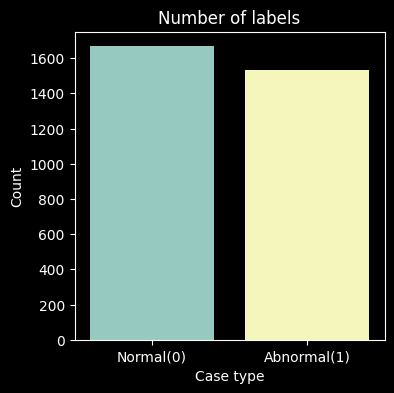

In [ ]:
#Count individual number of labels of images in validation set
cases_count = df['Valid_Label'].value_counts()
print(cases_count)

#Plot the results
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.style.use('dark_background')
plt.title('Number of labels', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

### Create Image Generators

In [ ]:
#Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set.csv", dtype=str)

datagen = ImageDataGenerator(rescale=1./255, rotation_range=30)

In [ ]:
#Image Preprocessing
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                              x_col="Train_Image", y_col="Train_Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=16, shuffle=True)

valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                              x_col="Valid_Image", y_col="Valid_Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=16, shuffle=True)

Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


## Create Model

In [ ]:
#Import DenseNet201
dense_model = DenseNet201(include_top=True, weights='imagenet')

82524592/82524592 [==============================] - 5s 0us/step


In [ ]:
dense_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

### Recalibrate

In [ ]:
#Pop off the last layer
dense_model.layers.pop()

In [ ]:
#Compile the model
predictions = Dense(1, activation='sigmoid')(dense_model.layers[-1].output)
model = Model(inputs=dense_model.input, outputs=predictions)

#Compile the model using binary accuracy and cross entropy
model.compile(optimizer = Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
#Number of train and validation steps
train_steps=train_generator.n//train_generator.batch_size
valid_steps=valid_generator.n//valid_generator.batch_size

In [ ]:
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=1, mode='max')

In [ ]:
#Fit the model
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=valid_generator,
                    validation_steps=valid_steps,
                    epochs=10,
                    callbacks=[checkpoint])

<ipython-input-23-7b886997076d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/10
2300/2300 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.6872

2300/2300 [==============================] - 879s 365ms/step - loss: 0.6610 - accuracy: 0.6872 - val_loss: 0.6601 - val_accuracy: 0.6737
Epoch 2/10
2300/2300 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.7121

2300/2300 [==============================] - 808s 351ms/step - loss: 0.6308 - accuracy: 0.7121 - val_loss: 0.6477 - val_accuracy: 0.6806
Epoch 3/10
2300/2300 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.7390

2300/2300 [==============================] - 803s 349ms/step - loss: 0.6034 - accuracy: 0.7390 - val_loss: 0.5980 - val_accuracy: 0.7491
Epoch 4/10
2300/2300 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.7567

2300/2300 [==============================] - 833s 362ms/step - loss: 0.5772 - accuracy: 0.7567 - val_loss: 0.5980 - val_accuracy: 0.7393
Epoch 5/10
2300/2300 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.7715

2300/2300 [==============================] - 836s 363ms/step - loss: 0.5533 - accuracy: 0.7715 - val_loss: 0.5650 - val_accuracy: 0.7563
Epoch 6/10
2300/2300 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.7787

2300/2300 [==============================] - 830s 361ms/step - loss: 0.5351 - accuracy: 0.7787 - val_loss: 0.6564 - val_accuracy: 0.6542
Epoch 7/10
2300/2300 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.7883

2300/2300 [==============================] - 832s 362ms/step - loss: 0.5165 - accuracy: 0.7883 - val_loss: 0.5425 - val_accuracy: 0.7591
Epoch 8/10
2300/2300 [==============================] - ETA: 0s - loss: 0.4992 - accuracy: 0.7967

2300/2300 [==============================] - 833s 362ms/step - loss: 0.4992 - accuracy: 0.7967 - val_loss: 0.5314 - val_accuracy: 0.7632
Epoch 9/10
2300/2300 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.7994

2300/2300 [==============================] - 840s 365ms/step - loss: 0.4870 - accuracy: 0.7994 - val_loss: 0.5152 - val_accuracy: 0.7748
Epoch 10/10
2300/2300 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.8069

2300/2300 [==============================] - 843s 366ms/step - loss: 0.4736 - accuracy: 0.8069 - val_loss: 0.4929 - val_accuracy: 0.7871


## Evaluate

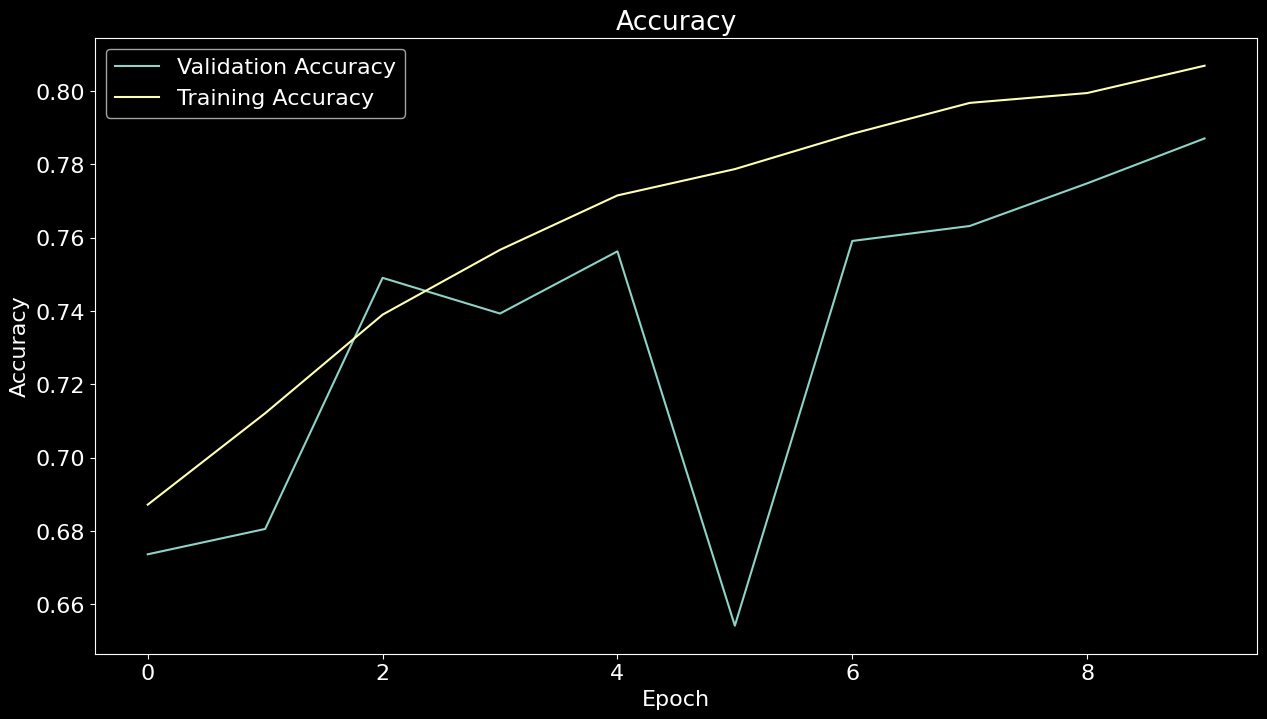

Best Validation Accuracy: 0.7870603203773499


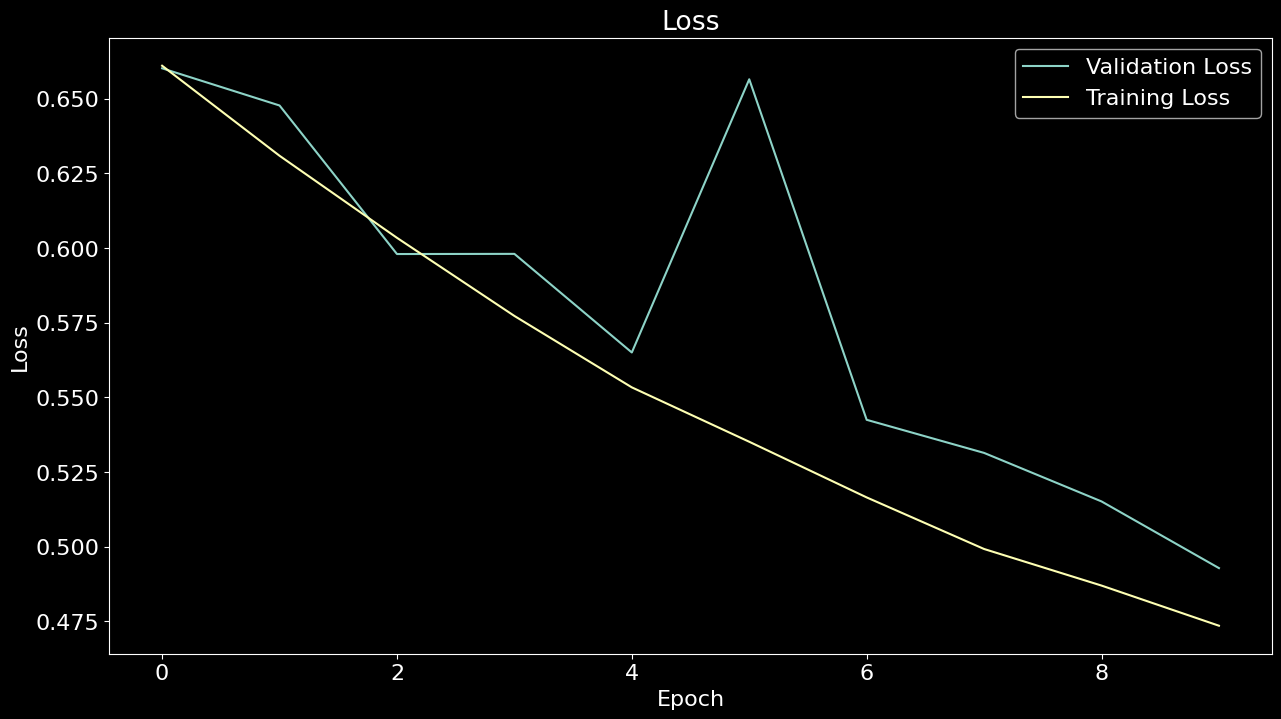

Smallest Validation Loss: 0.4928516745567322


In [ ]:
# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 16
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find and print the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy)



# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 16
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find and print the smallest validation loss
smallest_val_loss = min(history.history['val_loss'])
print("Smallest Validation Loss:", smallest_val_loss)